In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# data manipulation
import numpy as np
import pandas as pd
import datetime
from pathlib import Path

# import progress bar
from tqdm.auto import tqdm

# yahoo finance
import yfinance as yf

# plotting & outputs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# normality test
from scipy.stats import shapiro

# pandas ta
import pandas_ta as ta

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Borutapy
from boruta import BorutaPy

# sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, roc_auc_score

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D
from tensorflow.keras import Input

# keras tuner
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner import HyperParameters
import kerastuner

In [2]:
# define seed
def set_seeds(seed=42): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

## Obtain and clean AMD dataset
We will be using AMD daily stock price for time period between 2017-01-01 and 2024-03-01.

In [3]:
# download price data
amd = yf.download("AMD",start="2017-01-01",end="2024-03-01")

[*********************100%***********************]  1 of 1 completed


In [4]:
# check for null
amd.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

The dataset does not contain any nulls.

## Defining the target variable
1 indicates an up-move, and 0 otherwise. We are now going to define the threshold level for an up-move, where any returns above this threshold level is going to be classified as an up-move, vice versa.

In [5]:
# compute the returns
df = amd
df["returns"] = np.log(df["Adj Close"]/df["Adj Close"].shift(1))

# drop emtpy row
df = df.dropna()

ATR is the moving window average of the TR (True Range), where TR is the maximum of either (i) the current period's high minus low, (ii) the absolute value of the current period's high minus the previous period's close, or (iii) the absolute value of the current period's low minus the previous period's close. The formula below shows how ATR is computed:

$$ATR = \frac{1}{n} \sum_{i=1}^{n} \text{TR}_i$$

In our case, the threshold level is going to be 0.1 times the ATR value.

In [6]:
# define ATR function
def compute_atr(high_prices, low_prices, close_prices, n=14):
    atr_values = []

    for i in range(len(high_prices)):
        if i == 0:
            atr_values.append(high_prices[i] - low_prices[i])
        else:
            tr = max(high_prices[i] - low_prices[i],
                     abs(high_prices[i] - close_prices[i-1]),
                     abs(low_prices[i] - close_prices[i-1]))
            atr_values.append(tr)

    atr = [np.mean(atr_values[max(0, i-n+1):i+1]) for i in range(len(atr_values))]
    return np.array(atr)

In [7]:
# compute ATR values
atr_values = compute_atr(df["High"], df["Low"], df["Adj Close"], n=30)

# add ATR to the dataframe
df["ATR"] = atr_values

In [8]:
# compute threshold values
multiplier = 0.1
threshold = np.array(atr_values) * multiplier

In [9]:
# compute the dollar change in price
dif = df["Adj Close"] - df["Adj Close"].shift(1)

# add target variable to the dataframe
df["Signal"] = np.where(dif>threshold, 1, 0)

In [10]:
# shift the "signal" column
df["Signal"] = df["Signal"].shift(-1)

## Features Engineering

#### Momentum TA

In [11]:
# features with only 1 variation
df = pd.concat([df,amd.ta.bop()], axis=1)

In [12]:
# fast and slow params
mom_fs_param = ['amd.ta.ao(fast=f,slow=s)','amd.ta.apo(fast=f, slow=s)','amd.ta.tsi(fast=f,slow=s)']
for feat in mom_fs_param:
    for f, s in zip([5,10],[20,30]):
        df = pd.concat([df,eval(feat)], axis=1)

In [13]:
# features with length param
mom_l_param = ['amd.ta.bias(length=i)','amd.ta.inertia(length=i)', 'amd.ta.cci(length=i)',
               'amd.ta.pgo(length=i)','amd.ta.psl(length=i)','amd.ta.rsi(length=i)',
               'amd.ta.coppock(length=i)','amd.ta.cti(length=i)', 'amd.ta.er(length=i)',
               'amd.ta.fisher(length=i)']

for feat in mom_l_param:
    for i in [2,5,10,20,30]:
        df = pd.concat([df,eval(feat)], axis=1)

#### Volume TA

In [14]:
# features with only 1 variation
for feat in ['amd.ta.obv()','amd.ta.pvol()','amd.ta.pvr()','amd.ta.pvt()']:
    df = pd.concat([df,eval(feat)], axis=1)

In [15]:
# fast and slow params
volume_fs_param = ['amd.ta.kvo(fast=f,slow=s)']
for feat in volume_fs_param:
    for f, s in zip([30,40],[50,60]):
        df = pd.concat([df,eval(feat)], axis=1)

In [16]:
# features with length param
volume_l_param = ['amd.ta.cmf(length=i)','amd.ta.efi(length=i)',
                  'amd.ta.eom(length=i)','amd.ta.mfi(length=i)']
for feat in volume_l_param:
    for i in [2,5,10,20,30]:
        df = pd.concat([df,eval(feat)], axis=1)

volume_l_param_2 = ['amd.ta.nvi(length=i)','amd.ta.pvi(length=i)']
for feat in volume_l_param_2:
    for i in [1,5,10]:
        df = pd.concat([df,eval(feat)], axis=1)

#### Volatility TA

In [17]:
# features with only 1 vairation
df = pd.concat([df,amd.ta.pdist()], axis=1)

In [18]:
# features with fast and slow parameters
volatility_fs_param = ['amd.ta.massi(fast=f,slow=s)']
for feat in volatility_fs_param:
    for f, s in zip([10,20],[25,35]):
        df = pd.concat([df,eval(feat)], axis=1)

In [19]:
# features with length param
volatility_l_param = ['amd.ta.accbands(length=i)','amd.ta.atr(length=i)',
                      'amd.ta.bbands(length=i)','amd.ta.kc(length=i)']

for feat in volatility_l_param:
    for i in [2,5,10,20,30]:
        df = pd.concat([df,eval(feat)], axis=1)

#### Trend TA

In [20]:
# Simple Moving Average
for i in np.arange(5,36,10):
    sma = amd.ta.sma(length=i)
    df = pd.concat([df, sma], axis=1)

In [21]:
# Exponential Moving Average
for i in np.arange(5,36,10):
    ema = amd.ta.ema(length=i)
    df = pd.concat([df, ema], axis=1)

In [22]:
# features with length param
trend_l_param = ['amd.ta.adx(length=i)','amd.ta.chop(length=i)','amd.ta.decay(length=i)',
                 'amd.ta.qstick(length=i)','amd.ta.ttm_trend(length=i)','amd.ta.vhf(length=i)']

for feat in trend_l_param:
    for i in [2,5,10,20,30]:
        df = pd.concat([df,eval(feat)], axis=1)

#### Performance TA

In [23]:
# Lagged Returns
for i in [2, 4, 8, 16, 32]:
    df[f"lagged_ret_{i}"] = df["returns"].shift(i)

In [24]:
# Momentum
for i in [2, 4, 8, 16, 32]:
    df[f"momentum_{i}"] = df["Adj Close"].pct_change(i)

## Exploratory Data Analysis (EDA) (Part 1)

**Dropping unnecessary columns**

In [25]:
# dropping unnecessary columns
df = df.drop(["Open","High","Low","Close","Adj Close","Volume","returns","ATR"],axis=1)

In [26]:
# the shape of df
df.shape

(1801, 220)

**Summary statistics**

In [27]:
# summary statistics
df.describe()

,Signal,BOP,AO_5_20,AO_10_30,APO_5_20,APO_10_30,TSI_5_20_13,TSIs_5_20_13,TSI_10_30_13,TSIs_10_30_13,...,lagged_ret_2,lagged_ret_4,lagged_ret_8,lagged_ret_16,lagged_ret_32,momentum_2,momentum_4,momentum_8,momentum_16,momentum_32
count,1799.000000,1801.000000,1782.000000,1772.000000,1782.000000,1772.000000,1777.000000,1765.000000,1762.000000,1750.000000,...,1798.000000,1796.000000,1792.000000,1784.000000,1768.000000,1798.000000,1796.000000,1792.000000,1784.000000,1768.000000
mean,0.440245,0.002480,0.688403,0.914485,0.689341,0.915046,7.306505,7.205009,7.190093,7.128392,...,0.001527,0.001524,0.001519,0.001506,0.001443,0.004285,0.008526,0.016894,0.034460,0.068681
std,0.496554,0.533943,4.569087,4.994921,4.581155,5.008567,25.626361,21.787783,20.602165,18.762122,...,0.035084,0.035103,0.035034,0.035091,0.035076,0.048656,0.068646,0.095535,0.137532,0.200349
min,0.000000,-1.000000,-19.664000,-17.663667,-19.080501,-17.777667,-54.476685,-45.641902,-42.870822,-39.426382,...,-0.277456,-0.277456,-0.277456,-0.277456,-0.277456,-0.237151,-0.328418,-0.382784,-0.383912,-0.474328
25%,0.000000,-0.454545,-1.095749,-1.085251,-1.065375,-1.114250,-11.106395,-8.261910,-7.409364,-6.544074,...,-0.016653,-0.016665,-0.016638,-0.016697,-0.016638,-0.024533,-0.033360,-0.044133,-0.053045,-0.076733
50%,0.000000,-0.017700,0.337375,0.356917,0.337250,0.363000,5.178759,4.826299,4.981457,5.263844,...,0.000694,0.000694,0.000725,0.000752,0.000694,0.001471,0.007749,0.015446,0.018080,0.049482
75%,1.000000,0.466667,2.254437,2.551292,2.220499,2.500083,25.981061,22.430477,20.725029,19.751662,...,0.020215,0.020242,0.020242,0.020290,0.020290,0.031025,0.049686,0.073536,0.122961,0.197471
max,1.000000,0.980311,19.514000,19.417166,19.873997,19.654666,76.693267,61.924056,62.697644,55.990416,...,0.181889,0.181889,0.181889,0.181889,0.181889,0.268052,0.314368,0.427564,0.612112,0.862305


We can obviously see that there are missing values in most features.

**Check the features' data type**

In [28]:
df_cleaned = df.copy()

In [29]:
# check data type
data_type = df_cleaned.dtypes
float_features = np.where(data_type==("float64"),1,0).sum()
int_features = np.where(data_type==("int32"),1,0).sum()
object_features = np.where(data_type=="object",1,0).sum()
print(f"The number of featues with float data type: {float_features}")
print(f"The number of featues with integer data type: {int_features}")
print(f"The number of featues with object data type: {object_features}")

The number of featues with float data type: 215
The number of featues with integer data type: 5
The number of featues with object data type: 0


**Addressing nulls in the dataset**

In [30]:
# check for null values
nulls = df_cleaned.isnull().sum()

null_columns = np.where(nulls>0, nulls.keys(), np.nan)
len(pd.Series(null_columns).dropna())

200

200 out of the 247 columns (246 features + 1 target variable) contain nulls.

In [31]:
# remove the last row of the dataset to address the null in the "Signal" column
df_cleaned.drop(index=df_cleaned.index[-1],axis=1,inplace=True)

In [32]:
# perform forward fill
df_cleaned = df_cleaned.ffill()

In [33]:
# the number of nulls of feature with the most number of empty cells at the start 
lrg = df_cleaned.isnull().sum().max()

# drop the first few rows
df_cleaned.drop(index=df_cleaned.index[:lrg], inplace=True)

## Separate the features and the target variable

In [34]:
# Features dataset
X = df_cleaned.iloc[:,1:]

In [35]:
# Target variable
y = df_cleaned[["Signal"]]

## Check and address class imbalance

In [36]:
# check for class imbalance
    # class 1
cls_1 = np.where(y==1, True, False).sum()
    # class 0
cls_0 = np.where(y==0, True, False).sum()

print(f"Number of data points in class 1: {cls_1}")
print(f"Number of data points in class 0: {cls_0}")

Number of data points in class 1: 763
Number of data points in class 0: 965


Given the above result, the dataset is imbalanced, i.e. the number of data points in each class are not equal.

And so, we are going to find the appropriate weights for the data points in each class, such that the dataset becomes balanced.

In [37]:
# apply the appropriate weight to each class
# let's set the weight of class 0 equal to 1.0
w_0 = 1.0
w_1 = (cls_0 * w_0) / cls_1

class_weight = {0: w_0, 1: w_1}
print(class_weight)

{0: 1.0, 1: 1.2647444298820445}


By applying a class weight of 1.0 and 1.265 to the data points in class 0 and 1, respectively, we would now have a balanced dataset.

In [38]:
# With the calculated weights, both classes gain equal weight
print(class_weight[0] * cls_0)
print(class_weight[1] * cls_1)

965.0
965.0


## Time Series Split
Split the original dataset into training, validation, and testing dataset.

In [39]:
# split the original dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# split the training dataset into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False, random_state=42)

print(f"Train, validation, and Test Size: {X_train.shape}, {y_train.shape}, {X_val.shape}, {y_val.shape}, {X_test.shape}, {y_test.shape}")

Train, validation, and Test Size: (1036, 219), (1036, 1), (346, 219), (346, 1), (346, 219), (346, 1)


In [40]:
# Time period for training, validation, and testing dataset
def d_time(name, data):
    print(f'{name} {data.index[0]} - {data.index[-1]}')

d_time("Training dataset:", X_train)
d_time("Validation dataset:", X_val)
d_time("Testing dataset:", X_test)

Training dataset: 2017-04-18 00:00:00 - 2021-05-27 00:00:00
Validation dataset: 2021-05-28 00:00:00 - 2022-10-11 00:00:00
Testing dataset: 2022-10-12 00:00:00 - 2024-02-28 00:00:00


After the dataset has been split, we would need to address data leakage. The bullet points below are going to discuss the 2 sources of data leakage and how it can be addressed:
- Computing the features requires the use of data points from few periods in the past. Hence, we need to drop the first few data points in the beginning of the validation and testing dataset, such that there is no overlap between the 3 datasets.
- Computing the target variable requires the use of a data point from one period in the future. Hence, we need to drop the last row of the training and validation dataset.


In [41]:
# adjust the splitted data to prevent data leakage due to the lookback period
    # validation dataset
X_val = X_val.drop(index=X_val.index[:lrg])
y_val = y_val.drop(index=y_val.index[:lrg])
    # testing dataset
X_test = X_test.drop(index=X_test.index[:lrg])
y_test = y_test.drop(index=y_test.index[:lrg])

In [42]:
# adjust the splitted data to prevent data leakage due to the "signal" column
    # training dataset
X_train = X_train.drop(index=X_train.index[-1])
y_train = y_train.drop(index=y_train.index[-1])
    # validation dataset
X_val = X_val.drop(index=X_val.index[-1])
y_val = y_val.drop(index=y_val.index[-1])

In [43]:
# shape post-dropping
print(f"Train and Test Size {X_train.shape}, {y_train.shape}, {X_val.shape}, {y_val.shape}, {X_test.shape}, {y_test.shape}")

Train and Test Size (1035, 219), (1035, 1), (273, 219), (273, 1), (274, 219), (274, 1)


## Exploratory Data Analysis (EDA) (Part 2)

**Check for outliers**

(Note that this is to be performed on the training dataset only. This is because the result of from this outlier check is going to affect the decision on what type of feature scaling is to be performed. Hence, we are preventing data leakage.)

To check for the presence of outliers in our features, we have performed the Tukey's Fences rule: Data points below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR are considered potential outliers.

In [44]:
features_list = X_train.columns

In [45]:
# Detecting for anomalies
features_anomaly = []
features_non_anomaly = []
for i in features_list:
    # Compute the IQR
    Q1 = X_train[i].quantile(0.25)
    Q3 = X_train[i].quantile(0.75)
    IQR = Q3 - Q1
    
    # Applying Tukey's Fences rule
    lower_outliers = np.where(X_train[i]<(Q1-1.5*IQR), 1, 0).sum()
    upper_outliers = np.where(X_train[i]>(Q3+1.5*IQR), 1, 0).sum()
    
    if (lower_outliers > 0) or (upper_outliers > 0):
        features_anomaly.append(i)
    else:
        features_non_anomaly.append(i)

In [46]:
# number of features with and without anomaly
print(f"The number of features that contains anomaly: {len(features_anomaly)}")
print(f"The number of features that does not contain any anomaly: {len(features_non_anomaly)}")

The number of features that contains anomaly: 114
The number of features that does not contain any anomaly: 105


**Analyze the distribution of each features**

(Note that this is to be performed on the training dataset only. This is because the result of from this analysis on the distribution is going to affect the decision on what type of feature scaling is to be performed. Hence, we are preventing data leakage.)

We are going to check which features are normally distributed using the Shapiro test.

In [47]:
# Collect the features that are normally distributed
normal_features = []
for i in X_train.columns:
    # Perform Shapiro-Wilk test
    stat, p = shapiro(X_train[i])
    
    # Set significance level
    alpha = 0.05
    
    # Collect the features that are normally distributed
    if p > alpha:
        normal_features.append(i)

print(normal_features)
print(f"The number of normally distributed features: {len(normal_features)}")

['PGO_2', 'DMN_20']
The number of normally distributed features: 2


**Analyze multicollinearity**

Although challenging, we technically could analyze multicollinearity between features by computing the correlation matrix. However, it is not ideal because the correlation coefficient only measures the correlation between 2 variables/features, hence it is not explicit in indicating the presence of multicollinearity. Therefore, we would look to a measure called VIF (Variance Inflationary Factor), which is a more direct way to analyze multicollinearity.

The VIF of *a feature* is computed as follows:
1. Perform linear regression on a feature with respect to the other features.
2. Compute the $R^2$ value.
3. VIF is computed using the formula below:
$$\text{VIF}=\frac{1}{1-R^2}$$

The VIF score can be interpreted as follows:
- VIF = 1 is the smallest possible VIF value. It indicates that the feature exhibit no multicollinearity with the other features.
- 1 < VIF < 5 indicates the feature exhibit a weak multicollinearity.
- 5 < VIF < 10 indicates that the feature exhibits a moderate level of multicollinearity.
- VIF > 10 indicates that that the feature exhibits a strong multicollinearity

In [48]:
# compute the vif for all given features
def compute_vif(X):
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(len(X.columns))]
    vif = vif.sort_values("VIF", ascending=False)
    
    # reset the index of the dataframe
    vif = vif.reset_index()
    vif.drop("index",axis=1,inplace=True)
    return vif

In [49]:
# compute VIF (on training dataset)
df_vif = compute_vif(X_train)

In [50]:
df_vif

,Variable,VIF
0,EMA_5,9.007199e+15
1,KCBe_2_2,9.007199e+15
2,KCBe_5_2,9.007199e+15
3,KCBe_10_2,4.503600e+15
4,BBM_30_2.0,3.002400e+15
...,...,...
214,CHOP_2_1_100,3.407249e+00
215,ER_5,2.800560e+00
216,VHF_2,2.743290e+00
217,lagged_ret_32,2.275696e+00


In [51]:
# features with VIF > 10
np.where(df_vif["VIF"] > 10, True, False).sum()

194

In [52]:
# features with 5 < VIF < 10
len([i for i in df_vif["VIF"] if (i > 5) and (i < 10)])

16

In [53]:
# features with 5 > VIF
len([i for i in df_vif["VIF"] if (i < 5)])

9

## Feature Scaling
There will be 3 different types of scaling that will be performed on the numerical features: Standard Scaling, Min Max Scaling, and Robust Scaling.
- If the feature is normally distributed, we will be applying the Standard Scaling.
- If the feature is not normally distributed and there are not any extreme anomalies in the data points, we will be applying Min Max Scaling.
- If the feature is not normally distributed and there are extreme anomalies in the data points, we will be applying Robust Scaling.

In [54]:
# features to be scaled using standard scaling
standard_features = normal_features.copy()

In [55]:
# features to be scaled with robust scaling
robust_features = features_anomaly.copy()
    # dropping features that overlap with standard_features
for i in standard_features:
    if i in robust_features:
        robust_features.remove(i)

In [56]:
# features to be scaled with minmax scaling
minmax_features = features_non_anomaly
    # dropping features that overlap with standard_features
for i in standard_features:
    if i in minmax_features:
        minmax_features.remove(i)

In [57]:
# define ColumnTransformer object
col_transformer = ColumnTransformer([("standard scaler",StandardScaler(),standard_features),
                                     ("minmax scaler",MinMaxScaler(),minmax_features),
                                     ("robust scaler",RobustScaler(),robust_features)],
                                    remainder="passthrough")

In [58]:
# perform transformation
X_train_scaled = col_transformer.fit_transform(X_train)
X_val_scaled = col_transformer.transform(X_val)
X_test_scaled = col_transformer.transform(X_test)

In [59]:
# the order of the columns after using ColumnTransformer
col_trans = standard_features + minmax_features + robust_features

# convert to dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=col_trans)
X_val_scaled_df = pd.DataFrame(X_val_scaled,columns=col_trans)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=col_trans)

## Feature Selection
We are going to perform feature selection using the following techniques: VIF, Boruta, and RFE (Recursive Feature Elimination). We are then going to use 3 different combinations of these methodologies to generate 3 different sets of features:
- Boruta + VIF-based feature selection
- RFE with 10 selected features + VIF-based feature selection
- RFE with 20 selected features + VIF-based feature selection

### (i) Boruta + VIF features selection

#### Boruta

In [60]:
# define random forest classifier
forest_boruta = RandomForestClassifier(max_depth=5, class_weight=class_weight)

In [61]:
# set seed
set_seeds(seed=1)

# perform Boruta
bor = BorutaPy(estimator=forest_boruta, n_estimators="auto", max_iter=50, alpha=0.05, verbose=2)
bor.fit(np.array(X_train_scaled_df), np.array(y_train))

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	219
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	9 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	10 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	11 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	12 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	13 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	14 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	15 / 50
Confirmed: 	0
Tentative: 	3
Rejected: 	216
Iteration: 	16 / 50
Confirmed: 	1
Tentative: 	2
Rejected: 	216
I

BorutaPy(estimator=RandomForestClassifier(class_weight={0: 1.0,
                                                        1: 1.2647444298820445},
                                          max_depth=5, n_estimators=48,
                                          random_state=RandomState(MT19937) at 0x15A270D0540),
         max_iter=50, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x15A270D0540, verbose=2)

In [62]:
# confirmed features
confirmed_features = X_train_scaled_df.columns[bor.support_]
confirmed_features

Index(['INERTIA_10_14', 'DMN_2', 'lagged_ret_2'], dtype='object')

In [63]:
# tentative features
tentative_features = X_train_scaled_df.columns[bor.support_weak_]
tentative_features

Index([], dtype='object')

#### VIF
The function *vif_feature_selection(selected_features)* will perform VIF-based feature selection.

In [64]:
def vif_feature_selection(selected_features):
    '''
    selected_features -> the selected features presented in a list.
    '''
    # Compute VIF on the selected features
    df_vif_before = compute_vif(X_train_scaled_df[selected_features])
    
    # Applying VIF feature selection to address multicollieanrity
    X_temp = X_train_scaled_df[selected_features].copy()
    df_vif_after = df_vif_before.copy()
    while (df_vif_after["VIF"]<5).sum() != len(df_vif_after):
        X_temp = X_temp.drop(df_vif_after.loc[0,"Variable"],axis=1)
        df_vif_after = compute_vif(X_temp)
    
    return [df_vif_before, df_vif_after]

In [65]:
# VIF score before VIF-based feature selection
conf_tent = np.concatenate((confirmed_features, tentative_features))
df_vif_bor = vif_feature_selection(conf_tent)[0]
df_vif_bor

,Variable,VIF
0,lagged_ret_2,1.096186
1,DMN_2,1.083971
2,INERTIA_10_14,1.079746


In [66]:
# VIF score after VIF-based feature selection
df_vif_bor = vif_feature_selection(conf_tent)[1]
df_vif_bor

,Variable,VIF
0,lagged_ret_2,1.096186
1,DMN_2,1.083971
2,INERTIA_10_14,1.079746


Since all of remaining features had VIF score < 5, VIF-based feature selection does not eliminate any of the remaining features.

In [67]:
# update dataset
    # training
X_train_scaled_bor_vif = X_train_scaled_df.loc[:,df_vif_bor["Variable"]]
    # validation
X_val_scaled_bor_vif = X_val_scaled_df.loc[:,df_vif_bor["Variable"]]
    # testing
X_test_scaled_bor_vif = X_test_scaled_df.loc[:,df_vif_bor["Variable"]]

### (ii) RFE + VIF features selection

In [68]:
# define
forest_rfe = RandomForestClassifier(max_depth=20,
                                    random_state=111,
                                    class_weight=class_weight)

#### (iia) RFE with 10 selected features + VIF

**RFE**

In [69]:
# set seed
set_seeds(seed=42)

# perform RFE (10 selected features)
rfe_10 = RFE(forest_rfe, step=1, n_features_to_select=10,verbose=0)
rfe_10.fit(X_train_scaled,y_train)

RFE(estimator=RandomForestClassifier(class_weight={0: 1.0,
                                                   1: 1.2647444298820445},
                                     max_depth=20, random_state=111),
    n_features_to_select=10)

In [70]:
# list of selected features
rfe10_features = X_train_scaled_df.loc[:,rfe_10.support_].columns
rfe10_features

Index(['CMF_2', 'NVI_1', 'VHF_2', 'BIAS_SMA_2', 'INERTIA_10_14', 'DMN_2',
       'CHOP_5_1_100', 'VHF_30', 'lagged_ret_2', 'momentum_8'],
      dtype='object')

**VIF**

In [71]:
# VIF score before VIF-based feature selection
vif_feature_selection(rfe10_features)[0]

,Variable,VIF
0,CMF_2,4.653724
1,VHF_2,3.537322
2,NVI_1,3.211754
3,momentum_8,2.047974
4,DMN_2,1.845216
5,INERTIA_10_14,1.667042
6,BIAS_SMA_2,1.508148
7,VHF_30,1.225058
8,lagged_ret_2,1.200597
9,CHOP_5_1_100,1.104500


In [72]:
# VIF score after VIF-based feature selection
df_vif_rfe10 = vif_feature_selection(rfe10_features)[1]
df_vif_rfe10

,Variable,VIF
0,CMF_2,4.653724
1,VHF_2,3.537322
2,NVI_1,3.211754
3,momentum_8,2.047974
4,DMN_2,1.845216
5,INERTIA_10_14,1.667042
6,BIAS_SMA_2,1.508148
7,VHF_30,1.225058
8,lagged_ret_2,1.200597
9,CHOP_5_1_100,1.104500


Since all of remaining features had VIF score < 5, VIF-based feature selection does not eliminate any of the remaining features.

In [73]:
# update dataset
    # training
X_train_scaled_rfe_10_vif = X_train_scaled_df.loc[:,df_vif_rfe10["Variable"]]
    # validation
X_val_scaled_rfe_10_vif = X_val_scaled_df.loc[:,df_vif_rfe10["Variable"]]
    # testing
X_test_scaled_rfe_10_vif = X_test_scaled_df.loc[:,df_vif_rfe10["Variable"]]

#### (iib) RFE with 20 selected features + VIF

**RFE**

In [74]:
# set seed
set_seeds(seed=42)

# perform RFE (10 selected features)
rfe_20 = RFE(forest_rfe, step=1, n_features_to_select=20,verbose=0)
rfe_20.fit(X_train_scaled,y_train)

RFE(estimator=RandomForestClassifier(class_weight={0: 1.0,
                                                   1: 1.2647444298820445},
                                     max_depth=20, random_state=111),
    n_features_to_select=20)

In [75]:
# list of selected features
rfe20_features = X_train_scaled_df.loc[:,rfe_20.support_].columns
rfe20_features

Index(['ER_5', 'CMF_2', 'NVI_1', 'EMA_5', 'VHF_2', 'VHF_5', 'BIAS_SMA_2',
       'INERTIA_10_14', 'INERTIA_20_14', 'ER_20', 'FISHERTs_2_1', 'DMN_2',
       'CHOP_5_1_100', 'QS_2', 'VHF_30', 'lagged_ret_2', 'lagged_ret_8',
       'lagged_ret_16', 'lagged_ret_32', 'momentum_8'],
      dtype='object')

**VIF**

In [76]:
# VIF score before VIF-based feature selection
vif_feature_selection(rfe20_features)[0]

,Variable,VIF
0,NVI_1,17.729858
1,VHF_5,11.270900
2,EMA_5,11.102184
3,CMF_2,9.633522
4,INERTIA_10_14,5.973273
5,ER_5,5.770891
6,INERTIA_20_14,4.777057
7,VHF_2,4.206521
8,momentum_8,2.775245
9,ER_20,2.496574


In [77]:
# VIF score after VIF-based feature selection
df_vif_rfe20 = vif_feature_selection(rfe20_features)[1]
df_vif_rfe20

,Variable,VIF
0,ER_5,3.495785
1,VHF_2,3.163535
2,momentum_8,2.523596
3,ER_20,2.484621
4,VHF_30,2.353946
5,FISHERTs_2_1,2.214615
6,DMN_2,2.139205
7,EMA_5,1.975348
8,BIAS_SMA_2,1.661008
9,QS_2,1.575169


After VIF-based feature selection, only 16 features are left.

In [78]:
# update dataset
    # training
X_train_scaled_rfe_20_vif = X_train_scaled_df.loc[:,df_vif_rfe20["Variable"]]
    # validation
X_val_scaled_rfe_20_vif = X_val_scaled_df.loc[:,df_vif_rfe20["Variable"]]
    # testing
X_test_scaled_rfe_20_vif = X_test_scaled_df.loc[:,df_vif_rfe20["Variable"]]

## Restructure the dataset for compatibility with LSTM / 1-D CNN
Before we start using the *TimeseriesGenerator()* function, we first need to adjust the features and target datasets, because the *TimeseriesGenerator()* function assumes that we are predicting the target variable from the next time step.

The function *ts_generator(X_train, X_val, X_test, y_train, y_val, y_test)* defined below will perform this adjustment and then apply the *TimeseriesGenerator()* function.

In [80]:
def ts_generator (X_train, X_val, X_test, y_train, y_val, y_test):
    '''
    X_train, X_val, X_test -> are DataFrames
    y_train, y_val, y_test -> are DataFrames
    '''
    # adjust the target variable (adding an additional row at the beginning)
        # training target
    y_train_g = np.insert(y_train.values,0,0)
    y_train_g = y_train_g.reshape((len(y_train_g), 1))
        # validation target
    y_val_g = np.insert(y_val.values,0,0)
    y_val_g = y_val_g.reshape((len(y_val_g), 1))
        # training target
    y_test_g = np.insert(y_test.values,0,0)
    y_test_g = y_test_g.reshape((len(y_test_g), 1))


    # adjust the features datasets to match the length of the adjusted training dataset
        # convert dataframes into arrays
    train = X_train.values
    val = X_val.values
    test = X_test.values
        # a row of zeroes
    zrs_g = np.zeros((1,train.shape[1]))
        # training dataset
    X_train_g = np.concatenate((train, zrs_g), axis=0)
        # validation dataset
    X_val_g = np.concatenate((val, zrs_g), axis=0)
        # testing dataset
    X_test_g = np.concatenate((test, zrs_g), axis=0)
    
    # apply the TimeseriesGenerator()
        # training dataset
    g_train = TimeseriesGenerator(data = X_train_g,
                                  targets = y_train_g,
                                  length = 15,
                                  sampling_rate = 1,
                                  stride = 1,
                                  shuffle = False,
                                  batch_size = 32)
    # validation dataset
    g_val = TimeseriesGenerator(data = X_val_g,
                                  targets = y_val_g,
                                  length = 15,
                                  sampling_rate = 1,
                                  stride = 1,
                                  shuffle = False,
                                  batch_size = 32)
    # testing dataset
    g_test = TimeseriesGenerator(data = X_test_g,
                                  targets = y_test_g,
                                  length = 15,
                                  sampling_rate = 1,
                                  stride = 1,
                                  shuffle = False,
                                  batch_size = 32)
    
    return [g_train, g_val, g_test]

#### Features dataset after Boruta + VIF features selection

In [81]:
g_train_bor_vif, g_val_bor_vif, g_test_bor_vif = ts_generator(X_train_scaled_bor_vif,
                                                              X_val_scaled_bor_vif,
                                                              X_test_scaled_bor_vif,
                                                              y_train,
                                                              y_val,
                                                              y_test)

#### Features dataset after RFE with 10 selected features + VIF

In [82]:
g_train_rfe10_vif, g_val_rfe10_vif, g_test_rfe10_vif = ts_generator(X_train_scaled_rfe_10_vif,
                                                                    X_val_scaled_rfe_10_vif,
                                                                    X_test_scaled_rfe_10_vif,
                                                                    y_train,
                                                                    y_val,
                                                                    y_test)

#### Features dataset after RFE with 20 selected features + VIF

In [83]:
g_train_rfe20_vif, g_val_rfe20_vif, g_test_rfe20_vif = ts_generator(X_train_scaled_rfe_20_vif,
                                                                    X_val_scaled_rfe_20_vif,
                                                                    X_test_scaled_rfe_20_vif,
                                                                    y_train,
                                                                    y_val,
                                                                    y_test)

## Model Building and Performance Evaluation (CNN-LSTM)
1-Dimensional CNN, and then followed by LSTM layer/s as well as dense layer/s.

In [84]:
def CNN_LSTM(hp, input_shape):
    '''
    input_shape -> enter the input shape in a 2-dimensional tuple
    '''
    # hyper parameters to be tuned
        # number of dense layers
    layers_cnn = hp.Int("cnn layers", min_value=1, max_value=2, step=1)
    layers_lstm = hp.Int("lstm layers", min_value=0, max_value=1, step=1)
    layers_dense = hp.Int("dense layers", min_value=0, max_value=2, step=1)
        
        # number of neurons
    units_lstm_last = hp.Int("lstm units last", min_value=32, max_value=320, step=32)
    units_lstm = []
    for i in range(layers_lstm):
        units_lstm.append(hp.Int(f"lstm units {i+1}", min_value=32, max_value=320, step=32))
    units_dense = []
    for i in range(layers_dense):
        units_dense.append(hp.Int(f"dense units {i+1}", min_value=32, max_value=320, step=32))
    
        # number of filters
    filters_cnn = []
    for i in range(layers_cnn):
        filters_cnn.append(hp.Int(f"number of filters {i+1}", min_value=64, max_value=320, step=32))
        
        # size of filter
    filter_size_cnn = []
    for i in range(layers_cnn):
        filter_size_cnn.append(hp.Int(f"filter size {i+1}", min_value=3, max_value=5, step=1))
    
        # activation function
    act_lstm_last = hp.Choice("activation lstm last", values=['tanh','relu', 'elu','selu'])
    act_dense=[]
    for i in range(layers_dense):
        act_dense.append(hp.Choice(f"activation dense {i+1}", values=['tanh','relu', 'elu','selu']))
    act_lstm = []
    for i in range(layers_lstm):
        act_lstm.append(hp.Choice(f"activation lstm {i+1}", values=['tanh','relu', 'elu','selu']))
        
        # dropouts
    dropout_lstm_last = hp.Float('lstm dropout last', min_value=0, max_value=0.3, step=0.1)
    dropout_dense = []
    for i in range(layers_dense):
        dropout_dense.append(hp.Float(f'dense dropout {i+1}', min_value=0, max_value=0.3, step=0.1))
    dropout_lstm = []
    for i in range(layers_lstm):
        dropout_lstm.append(hp.Float(f'lstm dropout {i+1}', min_value=0, max_value=0.3, step=0.1))
        
        # Tune the learning rate for the optimizer
    lear_rate_adam = hp.Choice('adam learning rate', values=[1e-2, 1e-3, 1e-4])
    
    
    # One layered LSTM
    cnn_lstm = Sequential()

    # input layer
    cnn_lstm.add(Input(shape=input_shape, name="Input"))
    
    # hidden layer
        # CNN layer/s
    for i in range(layers_cnn):
        cnn_lstm.add(Conv1D(filters=filters_cnn[i],
                            kernel_size=filter_size_cnn[i],
                            strides=1,
                            padding="same",
                            activation="relu",
                            name=f"cnn_{i+1}"))
        cnn_lstm.add(MaxPooling1D(pool_size=2, name=f"pooling_{i+1}"))
    
        # LSTM layer/s and dropout layer/s
    for i in range(layers_lstm):
        cnn_lstm.add(LSTM(units=units_lstm[i],
                          activation=act_lstm[i],
                          return_sequences=True,
                          name=f"lstm_{i+1}"))
        cnn_lstm.add(Dropout(rate=dropout_lstm[i],name=f"dropout_lstm_{i+1}"))
        # final LSTM layer
    cnn_lstm.add(LSTM(units=units_lstm_last, activation=act_lstm_last, return_sequences=False, name="lstm_last"))
    cnn_lstm.add(Dropout(rate=dropout_lstm_last, name="dropout_lstm_last"))
    
        # dense layers
    for i in range(layers_dense):
        cnn_lstm.add(Dense(units=units_dense[i], activation=act_dense[i], name=f"dense_{i+1}"))
        cnn_lstm.add(Dropout(rate=dropout_dense[i], name=f"dropout_dense_{i+1}"))
    
    # output layer
    cnn_lstm.add(Dense(units=1, activation="sigmoid", name='output'))
    
    # model compilation
    cnn_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lear_rate_adam, epsilon=1e-08),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics="accuracy")
    
    return cnn_lstm

The *param_tuning(model_architecture,training_dataset,validation_dataset,file_name,max_epochs=5)* function performs hyper-parameter tuning.

In [113]:
def param_tuning(model_architecture,training_dataset,validation_dataset,file_name):
    '''
    training_dataset and validation_dataset -> it should be generated from TimeseriesGenerator()
    file_name -> enter a string. It is the file name to which we will the hyperpameters from the tuning
    '''
    # extract the shape of the input
    num_feat = training_dataset[0][0][0].shape[1]
    num_time_steps = training_dataset[0][0][0].shape[0]
    input_shape = (num_time_steps,num_feat)

    # perform hyper parameter tuning
    tuner = RandomSearch(lambda hp: model_architecture(hp,input_shape),
                     objective="val_accuracy",
                     max_trials=5,
                     seed=123,
                     directory=f"Saved files/HyperPara_Tuning/{file_name}",
                     project_name="Sample_Tuning")
    
    early_stop = [tf.keras.callbacks.EarlyStopping("val_accuracy", patience=5, mode="max", restore_best_weights=True)]
    tuner.search(training_dataset,
                 epochs=30,
                 validation_data=validation_dataset,
                 callbacks=early_stop,
                 shuffle=False,
                 class_weight=class_weight)
    
    # print the best values for the hyper-parameters
    print("")
    print(tuner.get_best_hyperparameters()[0].values)
    
    # extract the best hyper parameters
    best_hyper_params = tuner.get_best_hyperparameters()[0]

    # build the NN model with the best hyper-parametrs
    best_model = tuner.hypermodel.build(best_hyper_params)
    
    # model summary
    return best_model

The *model_training(untrained_tuned_model, training_dataset, validation_dataset, file_name)* function will train the tuned model.

In [86]:
def model_training(untrained_tuned_model, training_dataset, validation_dataset, file_name):
    '''
    untrained_tuned_model -> LSTM_2 model that has its hyper-parameters already tuned, but not yet trained
    file_name -> enter a string. It is the file name to which we will save the ModelCheckpoint and TensorBoard
    '''
    # creating callbacks
    results_path = str(Path().cwd()/"Saved files"/"Model Checkpoint"/f"{file_name}"/"model.{epoch:02d}-{val_accuracy:.2f}.h5")

    callbacks=[EarlyStopping(patience=10, monitor="val_accuracy", mode="max", restore_best_weights=True, verbose=1),
               ModelCheckpoint(filepath=results_path, monitor="val_accuracy", save_best_only=True, verbose=1),
               TensorBoard(log_dir="Saved files/Tensor Board/{} {}".format(file_name, datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")))]

    # training the model
    set_seeds(1)
    untrained_tuned_model.fit(training_dataset,
                              epochs=200,
                              validation_data=validation_dataset,
                              callbacks=callbacks,
                              shuffle=False,
                              class_weight=class_weight)
    
    return untrained_tuned_model

The *performance_evaluation(model, test_dataset)* will evaluate the performance of the trained LSTM model (plotting the ROC curve and confusion matrix, as well as computing the ROC-AUC score and the classification report).

In [87]:
def performance_evaluation(model, test_dataset):
    '''
    model -> the trained NN model
    test_dataset -> it should be generated from TimeseriesGenerator()
    '''
    # make prediction on the test dataset
    pred = model.predict(test_dataset)
    pred = np.where(pred > 0.5, 1, 0)
    
    # extract the target variable of the test dataset from the output of TimeseriesGenerator()
    y_extracted = np.array([])
    for i in range(len(test_dataset)):
        y_extracted = np.concatenate((y_extracted, test_dataset[i][1].flatten()))
        
    # ROC_AUC value
    roc_auc_value = roc_auc_score(y_extracted, pred)
    print(f"The ROC-AUC value is {roc_auc_value}")
    
    # ROC_AUC plot
    fpr, tpr, thresholds = roc_curve(y_extracted, pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.show()
    
    # confusion matrix
    conf_matrix = confusion_matrix(y_extracted,pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format='d')
    ax.grid(False) # Turn off the grid
    plt.show()
    
    # classification report
    print(classification_report(y_extracted, pred))

**CNN-LSTM with features dataset after Boruta + VIF features selection**

In [114]:
# hyper-params tuning
CNN_LSTM_bor_vif = param_tuning(CNN_LSTM, g_train_bor_vif, g_val_bor_vif, "CNN_LSTM_bor_vif")

Trial 5 Complete [00h 00m 13s]
val_accuracy: 0.5675675868988037

Best val_accuracy So Far: 0.6138995885848999
Total elapsed time: 00h 02m 19s
INFO:tensorflow:Oracle triggered exit

{'cnn layers': 2, 'lstm layers': 1, 'dense layers': 2, 'lstm units last': 320, 'number of filters 1': 96, 'filter size 1': 4, 'activation lstm last': 'relu', 'lstm dropout last': 0.1, 'adam learning rate': 0.0001, 'lstm units 1': 128, 'dense units 1': 64, 'dense units 2': 192, 'activation dense 1': 'tanh', 'activation dense 2': 'elu', 'activation lstm 1': 'tanh', 'dense dropout 1': 0.0, 'dense dropout 2': 0.0, 'lstm dropout 1': 0.0, 'number of filters 2': 64, 'filter size 2': 3}


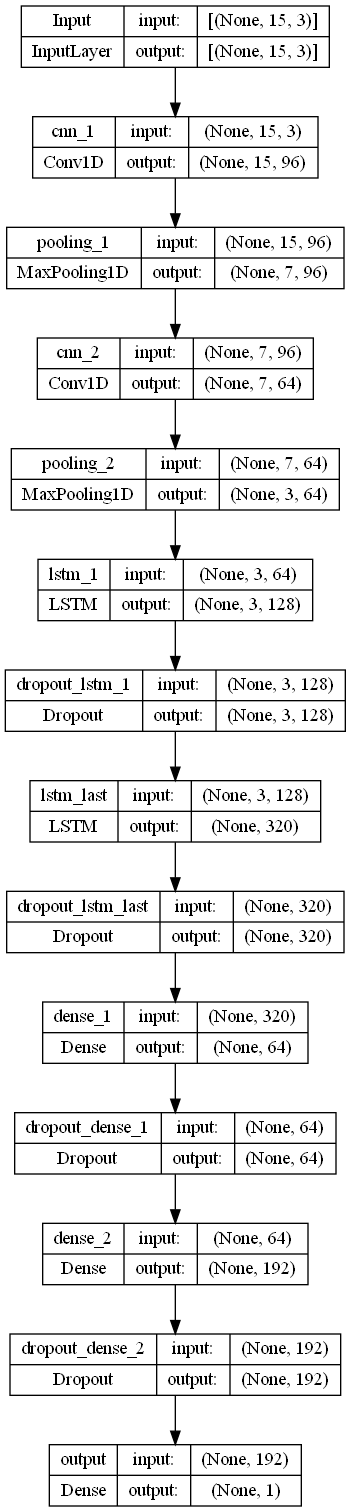

In [125]:
# vizualize the layers of the NN
tf.keras.utils.plot_model(CNN_LSTM_bor_vif, to_file='Saved files/NN Model Diagram/CNN_LSTM_bor_vif.png', show_shapes=True, show_layer_names=True)

In [115]:
# train the tuned model
set_seeds(1)
CNN_LSTM_bor_vif = model_training(CNN_LSTM_bor_vif, g_train_bor_vif, g_val_bor_vif, "CNN_LSTM_bor_vif")

Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.4554
Epoch 1: val_accuracy improved from -inf to 0.39382, saving model to C:\Users\User\CQF\Exam\Module 6\Saved files\Model Checkpoint\CNN_LSTM_bor_vif\model.01-0.39.h5
32/32 [==============================] - 8s 71ms/step - loss: 0.7765 - accuracy: 0.4554 - val_loss: 0.6971 - val_accuracy: 0.3938
Epoch 2/200
31/32 [============================>.] - ETA: 0s - loss: 0.7763 - accuracy: 0.4567
Epoch 2: val_accuracy did not improve from 0.39382
32/32 [==============================] - 1s 30ms/step - loss: 0.7759 - accuracy: 0.4535 - val_loss: 0.6985 - val_accuracy: 0.3938
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.4535
Epoch 3: val_accuracy did not improve from 0.39382
32/32 [==============================] - 1s 32ms/step - loss: 0.7755 - accuracy: 0.4535 - val_loss: 0.6991 - val_accuracy: 0.3938
Epoch 4/200
31/32 [============================>.] - ETA: 0

9/9 [==============================] - 1s 10ms/step
The ROC-AUC value is 0.5422297297297297


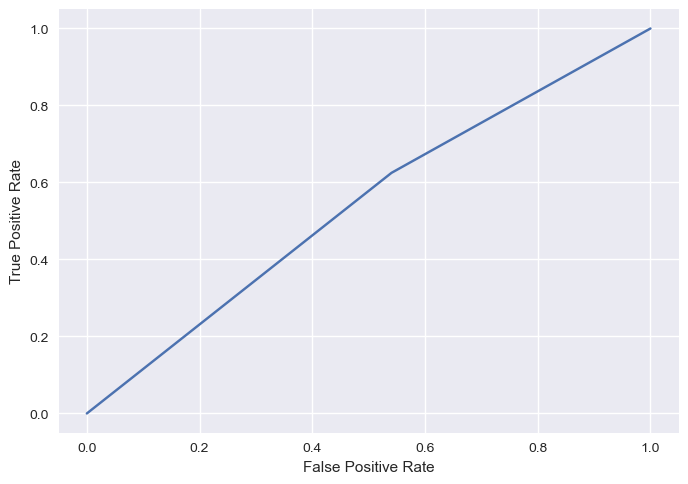

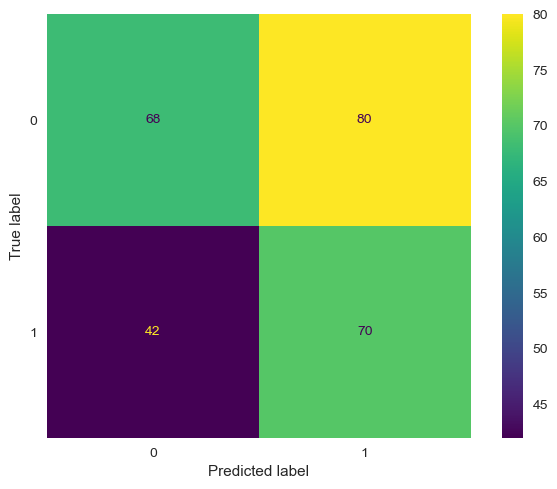

              precision    recall  f1-score   support

         0.0       0.62      0.46      0.53       148
         1.0       0.47      0.62      0.53       112

    accuracy                           0.53       260
   macro avg       0.54      0.54      0.53       260
weighted avg       0.55      0.53      0.53       260



In [116]:
# performance of the trained model using the test dataset
performance_evaluation(CNN_LSTM_bor_vif, g_test_bor_vif)

**CNN-LSTM with features dataset after RFE with 10 selected features + VIF**

In [117]:
# hyper-params tuning
CNN_LSTM_rfe10_vif = param_tuning(CNN_LSTM, g_train_rfe10_vif, g_val_rfe10_vif, "CNN_LSTM_rfe10_vif")

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.5675675868988037

Best val_accuracy So Far: 0.6061776280403137
Total elapsed time: 00h 01m 30s
INFO:tensorflow:Oracle triggered exit

{'cnn layers': 1, 'lstm layers': 1, 'dense layers': 2, 'lstm units last': 192, 'number of filters 1': 64, 'filter size 1': 5, 'activation lstm last': 'elu', 'lstm dropout last': 0.1, 'adam learning rate': 0.01, 'lstm units 1': 32, 'dense units 1': 32, 'dense units 2': 32, 'activation dense 1': 'tanh', 'activation dense 2': 'tanh', 'activation lstm 1': 'tanh', 'dense dropout 1': 0.0, 'dense dropout 2': 0.0, 'lstm dropout 1': 0.0}


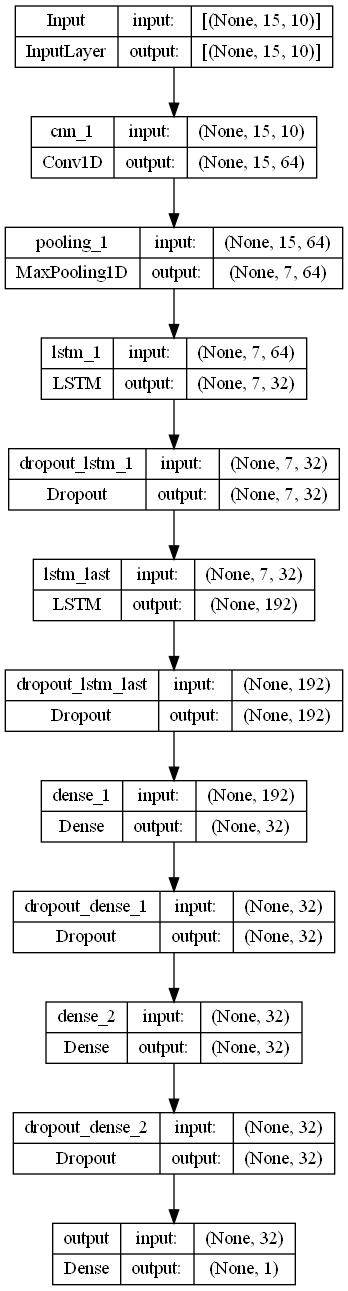

In [118]:
# vizualize the layers of the NN
tf.keras.utils.plot_model(CNN_LSTM_rfe10_vif, to_file='Saved files/NN Model Diagram/CNN_LSTM_rfe10_vif.png', show_shapes=True, show_layer_names=True)

In [119]:
# train the tuned model
set_seeds(1)
CNN_LSTM_rfe10_vif = model_training(CNN_LSTM_rfe10_vif, g_train_rfe10_vif, g_val_rfe10_vif,"CNN_LSTM_rfe10_vif")

Epoch 1/200
31/32 [============================>.] - ETA: 0s - loss: 0.8151 - accuracy: 0.5242
Epoch 1: val_accuracy improved from -inf to 0.60618, saving model to C:\Users\User\CQF\Exam\Module 6\Saved files\Model Checkpoint\CNN_LSTM_rfe10_vif\model.01-0.61.h5
32/32 [==============================] - 8s 62ms/step - loss: 0.8129 - accuracy: 0.5279 - val_loss: 0.6771 - val_accuracy: 0.6062
Epoch 2/200
31/32 [============================>.] - ETA: 0s - loss: 0.7815 - accuracy: 0.4778
Epoch 2: val_accuracy did not improve from 0.60618
32/32 [==============================] - 1s 25ms/step - loss: 0.7808 - accuracy: 0.4740 - val_loss: 0.6936 - val_accuracy: 0.4942
Epoch 3/200
30/32 [===========================>..] - ETA: 0s - loss: 0.7790 - accuracy: 0.4875
Epoch 3: val_accuracy did not improve from 0.60618
32/32 [==============================] - 1s 24ms/step - loss: 0.7782 - accuracy: 0.4858 - val_loss: 0.6917 - val_accuracy: 0.5405
Epoch 4/200
31/32 [============================>.] - ETA:

9/9 [==============================] - 1s 9ms/step
The ROC-AUC value is 0.5


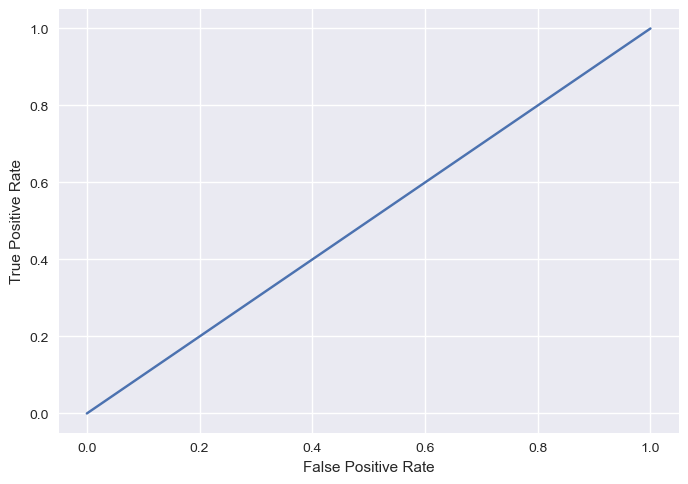

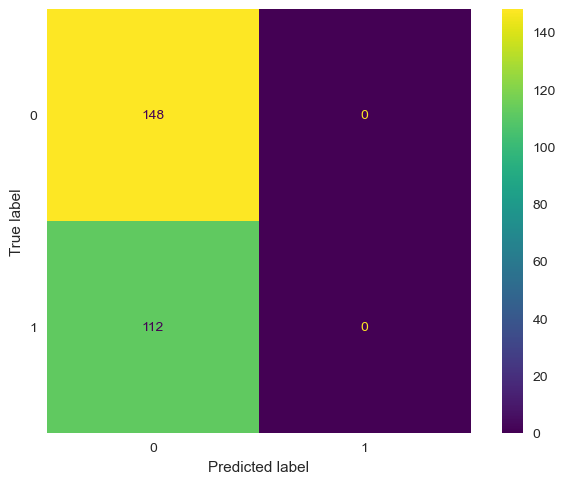

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       148
         1.0       0.00      0.00      0.00       112

    accuracy                           0.57       260
   macro avg       0.28      0.50      0.36       260
weighted avg       0.32      0.57      0.41       260



In [120]:
# performance of the trained model using the test dataset
performance_evaluation(CNN_LSTM_rfe10_vif, g_test_rfe10_vif)

**CNN-LSTM with features dataset after RFE with 20 selected features + VIF**

In [121]:
# hyper-params tuning
CNN_LSTM_rfe20_vif = param_tuning(CNN_LSTM, g_train_rfe20_vif, g_val_rfe20_vif, "CNN_LSTM_rfe20_vif")

Trial 5 Complete [00h 00m 14s]
val_accuracy: 0.5830115675926208

Best val_accuracy So Far: 0.6061776280403137
Total elapsed time: 00h 01m 33s
INFO:tensorflow:Oracle triggered exit

{'cnn layers': 1, 'lstm layers': 1, 'dense layers': 2, 'lstm units last': 192, 'number of filters 1': 64, 'filter size 1': 5, 'activation lstm last': 'elu', 'lstm dropout last': 0.1, 'adam learning rate': 0.01, 'lstm units 1': 32, 'dense units 1': 32, 'dense units 2': 32, 'activation dense 1': 'tanh', 'activation dense 2': 'tanh', 'activation lstm 1': 'tanh', 'dense dropout 1': 0.0, 'dense dropout 2': 0.0, 'lstm dropout 1': 0.0}


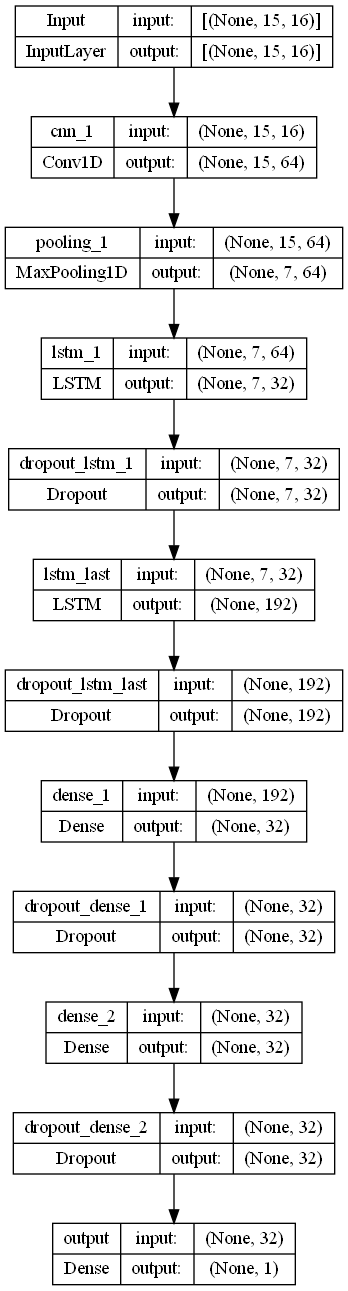

In [122]:
# vizualize the layers of the NN
tf.keras.utils.plot_model(CNN_LSTM_rfe20_vif, to_file='Saved files/NN Model Diagram/CNN_LSTM_rfe20_vif.png', show_shapes=True, show_layer_names=True)

In [123]:
# train the tuned model
set_seeds(1)
CNN_LSTM_rfe20_vif = model_training(CNN_LSTM_rfe20_vif, g_train_rfe20_vif, g_val_rfe20_vif,"CNN_LSTM_rfe20_vif")

Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 0.8196 - accuracy: 0.5191
Epoch 1: val_accuracy improved from -inf to 0.60618, saving model to C:\Users\User\CQF\Exam\Module 6\Saved files\Model Checkpoint\CNN_LSTM_rfe20_vif\model.01-0.61.h5
32/32 [==============================] - 7s 55ms/step - loss: 0.8196 - accuracy: 0.5191 - val_loss: 0.6788 - val_accuracy: 0.6062
Epoch 2/200
32/32 [==============================] - ETA: 0s - loss: 0.7801 - accuracy: 0.4770
Epoch 2: val_accuracy did not improve from 0.60618
32/32 [==============================] - 1s 26ms/step - loss: 0.7801 - accuracy: 0.4770 - val_loss: 0.6963 - val_accuracy: 0.3938
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 0.7779 - accuracy: 0.4829
Epoch 3: val_accuracy did not improve from 0.60618
32/32 [==============================] - 1s 31ms/step - loss: 0.7779 - accuracy: 0.4829 - val_loss: 0.6897 - val_accuracy: 0.5212
Epoch 4/200
32/32 [==============================] - ETA:

9/9 [==============================] - 1s 11ms/step
The ROC-AUC value is 0.5


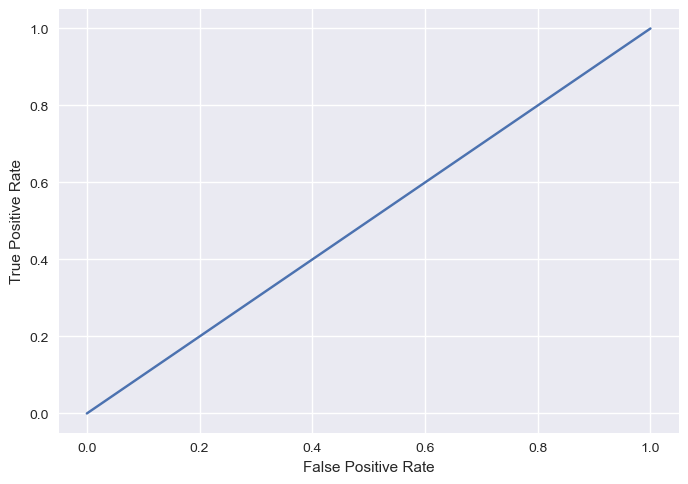

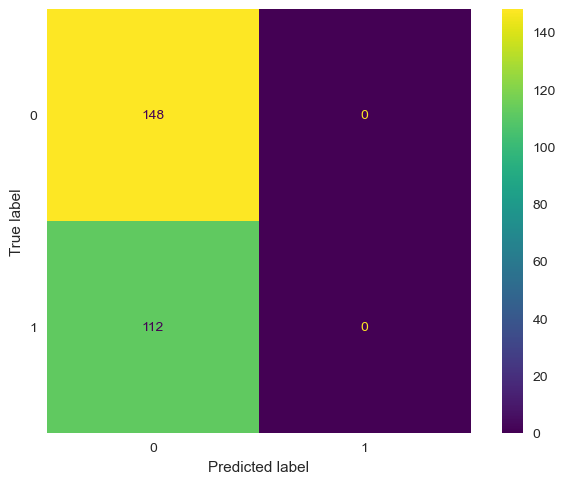

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       148
         1.0       0.00      0.00      0.00       112

    accuracy                           0.57       260
   macro avg       0.28      0.50      0.36       260
weighted avg       0.32      0.57      0.41       260



In [124]:
# performance of the trained model using the test dataset
performance_evaluation(CNN_LSTM_rfe20_vif, g_test_rfe20_vif)

Choosing the CNN_LSTM_bor_vif model, as it is the best performing model!

Both CNN_LSTM_rfe10_vif and CNN_LSTM_rfe20_vif would always predict a 0 signal, i.e. not making any trade.

## Evaluating the best set of model and features

In [126]:
# import pyfolio
import pyfolio as pf

### Back-testing period between 2023-02-16 and 2024-03-01

In [127]:
# make prediction on the test dataset
pred = CNN_LSTM_bor_vif.predict(g_test_bor_vif)
pred = np.where(pred > 0.5, 1, 0)

9/9 [==============================] - 0s 13ms/step


In [128]:
# extract the target variable of the test dataset from the output of TimeseriesGenerator()
y_extracted = np.array([])
for i in range(len(g_test_bor_vif)):
    y_extracted = np.concatenate((y_extracted, g_test_bor_vif[i][1].flatten()))

In [129]:
# create new dataframe
result_df = pd.DataFrame()

# append the closing price column
start = X_test.index[0]
end = X_test.index[-1]
result_df["Close"] = amd.loc[start:end,"Adj Close"]

# compute the returns
result_df["AMD Returns"] = (result_df["Close"] - result_df["Close"].shift(1))/result_df["Close"].shift(1)

# number of time-steps used in TimeseriesGenerator()
steps = 15

# compute the actual signal
result_df["Actual Signal"] = np.nan
result_df.iloc[steps-1:,-1] = y_extracted

# append the model's prediction
result_df["Model Signal"] = np.nan
result_df.iloc[steps-1:,-1] = pred.flatten()

# compute the model's returns
result_df["Model Returns"] = result_df["Model Signal"].shift(1) * result_df["AMD Returns"]

In [130]:
# address the nulls
result_df = result_df.iloc[result_df.isnull().sum().max():,:]

#### Monthly Returns

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

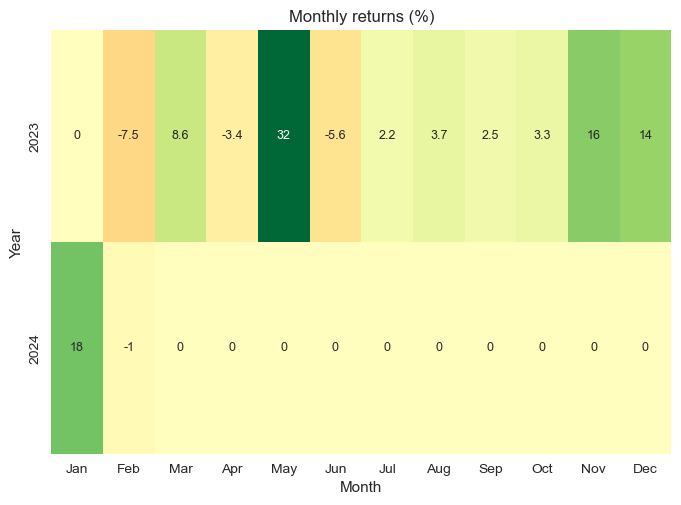

In [131]:
# plot monthly returns
pf.plotting.plot_monthly_returns_heatmap(result_df["Model Returns"])

#### Cumulative returns of the best model vs buy-and-hold on the AMD stock

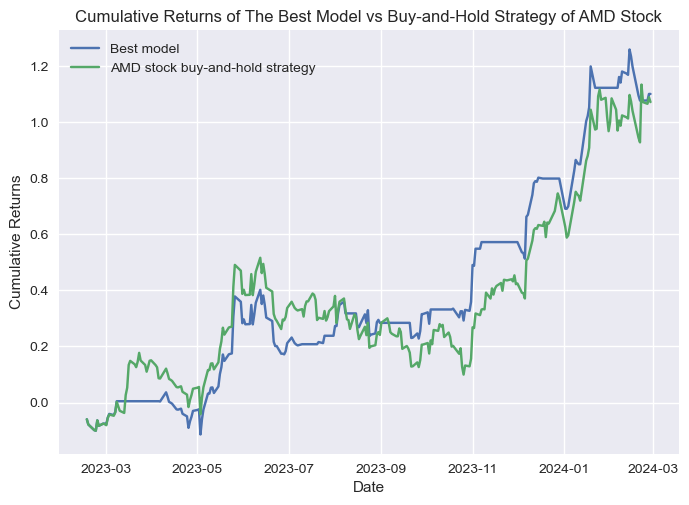

In [132]:
# compute cumulative returns of the model and amd
model_cum_ret = pf.timeseries.cum_returns(result_df["Model Returns"])
amd_cum_ret = pf.timeseries.cum_returns(result_df["AMD Returns"])

# plot the cumulative returns
fig, ax = plt.subplots()
ax.plot(model_cum_ret.index, model_cum_ret, label="Best model")
ax.plot(amd_cum_ret.index, amd_cum_ret, label="AMD stock buy-and-hold strategy")

ax.set_title("Cumulative Returns of The Best Model vs Buy-and-Hold Strategy of AMD Stock")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns")
ax.legend()
plt.show()

#### Cumulative returns of the best model vs buy-and-hold on the S&P500 index

In [133]:
# download benchmark (SPY EFT)
spy = yf.download("SPY", start="2023-02-16",end="2024-03-01")

# compute the returns of SPY
spy = spy[["Adj Close"]]
spy["Returns"] = spy["Adj Close"].pct_change()

# address the null
spy.dropna(axis=0, inplace=True)

[*********************100%***********************]  1 of 1 completed


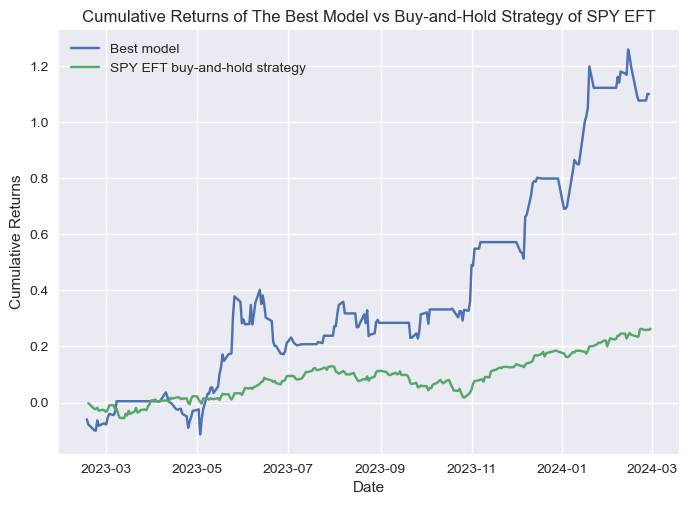

In [134]:
# compute cumulative returns of the model and amd
model_cum_ret = pf.timeseries.cum_returns(result_df["Model Returns"])
spy_cum_ret = pf.timeseries.cum_returns(spy["Returns"])

# plot the cumulative returns
fig, ax = plt.subplots()
ax.plot(model_cum_ret.index, model_cum_ret, label="Best model")
ax.plot(spy_cum_ret.index, spy_cum_ret, label="SPY EFT buy-and-hold strategy")

ax.set_title("Cumulative Returns of The Best Model vs Buy-and-Hold Strategy of SPY EFT")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns")
ax.legend()
plt.show()

#### Sharpe ratio and rolling Sharpe ratio

In [135]:
# Sharpe ratio of the model
pf.timeseries.perf_stats(result_df["Model Returns"])["Sharpe ratio"]

2.0971606690537103

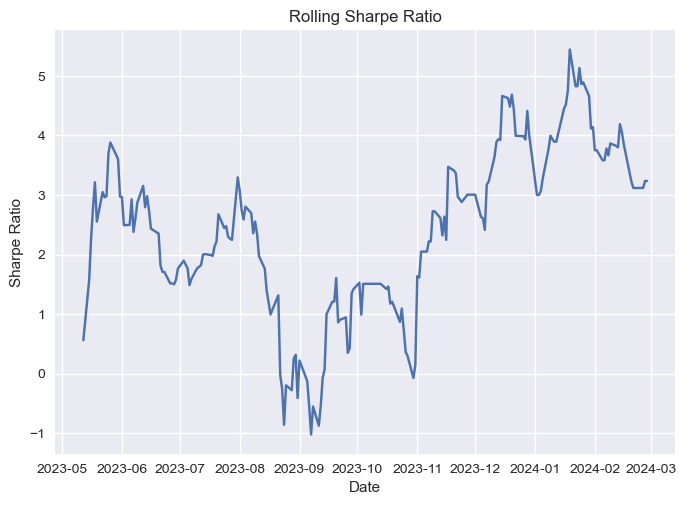

In [136]:
# Compute rolling Sharpe ratio of the model with window size of 60
model_rolling_sharpe = pf.timeseries.rolling_sharpe(result_df["Model Returns"], rolling_sharpe_window=60)

# plot the rolling sharpe ratio
fig, ax = plt.subplots()
ax.plot(model_rolling_sharpe.index, model_rolling_sharpe)

ax.set_title("Rolling Sharpe Ratio")
ax.set_xlabel("Date")
ax.set_ylabel("Sharpe Ratio")
plt.show()

#### Beta and Rolling Beta

In [137]:
# Compute beta
pf.timeseries.beta(result_df["Model Returns"],spy["Returns"])

1.0370806833758135

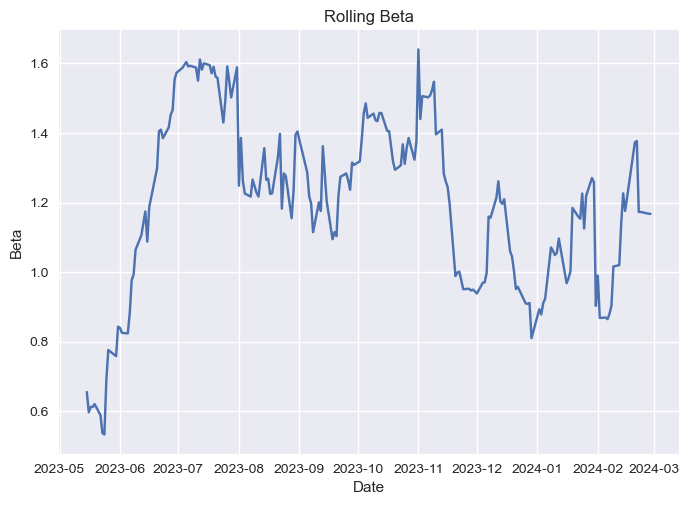

In [138]:
# Compute rolling beta
model_rolling_beta = pf.timeseries.rolling_beta(result_df["Model Returns"],spy["Returns"],rolling_window=60)

# plot the rolling beta
fig, ax = plt.subplots()
ax.plot(model_rolling_beta.index, model_rolling_beta)

ax.set_title("Rolling Beta")
ax.set_xlabel("Date")
ax.set_ylabel("Beta")
plt.show()

#### Alpha

In [139]:
# compute alpha
pf.timeseries.alpha(result_df["Model Returns"],spy["Returns"])

0.8475485115041683

#### Drawdowns

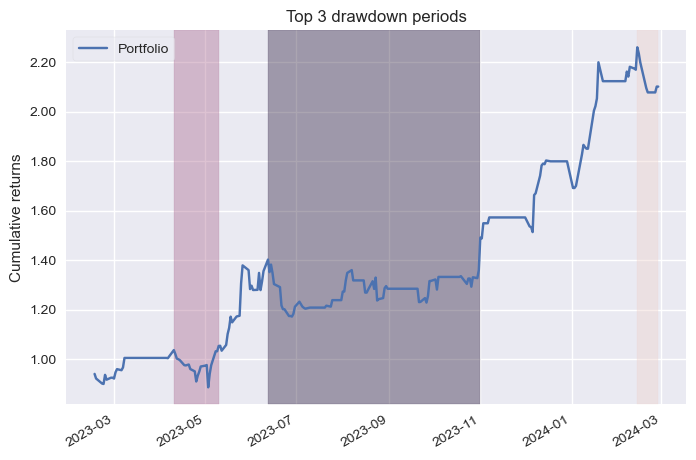

In [140]:
# Create a drawdown plot
pf.plotting.plot_drawdown_periods(result_df["Model Returns"], top=3)
plt.show()

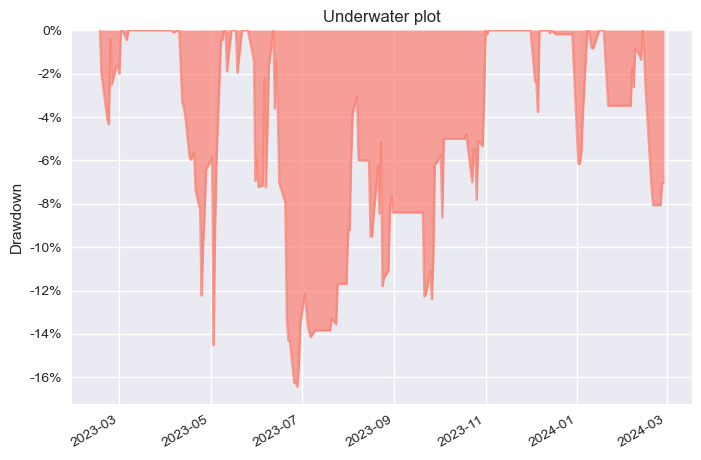

In [141]:
# create underwater plot
pf.plotting.plot_drawdown_underwater(result_df["Model Returns"])
plt.show()